# Getting Started:
## A simple driving model training and evaluation pipeline using the Drive360 dataset and PyTorch.

## Loading data from Drive360 dataset.

The **dataset.py** file contains the 3 classes necessary for creating a Drive360Loader. Using the **config.json** file to specify the location of the csv and data directory, we can generate phase (train, validation, test) specific data loaders that can output samples from each set. Adjust the **dataset.py** to your preferred training framework.

In [1]:
import json
from dataset import Drive360Loader

# load the config.json file that specifies data 
# location parameters and other hyperparameters 
# required.
config = json.load(open('./config_sample1_sample3_hybrid.json'))

# create a train, validation and test data loader
train_loader = Drive360Loader(config, 'train')
validation_loader = Drive360Loader(config, 'validation')
test_loader = Drive360Loader(config, 'test')

# print the data (keys) available for use. See full 
# description of each data type in the documents.
print('Loaded train loader with the following data available as a dict.')
print(train_loader.drive360.dataframe.keys())

total_batch = len(train_loader)

Phase: train # of data: 38876
Phase: validation # of data: 10554
Phase: test # of data: 27920
Loaded train loader with the following data available as a dict.
Index(['cameraRight', 'cameraFront', 'cameraRear', 'cameraLeft', 'canSteering',
       'canSpeed', 'chapter'],
      dtype='object')


In [2]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration >= total: 
        print()

## Training a basic driving model

Create your driving model. This is specific to your learning framework. 

Below we give a very basic dummy model that uses the front facing camera and a resnet34 + LSTM architecture to predict canSteering and canSpeed. 

In [3]:
from torchvision import models
import torch.nn as nn
import torch
    
class SomeDrivingModelResnet50(nn.Module):
    def __init__(self):
        super(SomeDrivingModelResnet50, self).__init__()
        final_concat_size = 0
        
        # Main CNN
        cnn = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(cnn.children())[:-1])
        self.intermediate = nn.Sequential(nn.Linear(
                          cnn.fc.in_features, 128),
                          nn.ReLU())
        final_concat_size += 128

        # Main LSTM
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=64,
                            num_layers=3,
                            batch_first=False)
        final_concat_size += 64
        
        # Angle Regressor
        self.control_angle = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.BatchNorm1d(64)
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(64)
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Speed Regressor
        self.control_speed = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.BatchNorm1d(64)
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(64)
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, data):
        module_outputs = []
        lstm_i = []
        # Loop through temporal sequence of
        # front facing camera images and pass 
        # through the cnn.
        for k, v in data['cameraFront'].items():
            v = v.cuda()
            x = self.features(v)
            x = x.view(x.size(0), -1)
            x = self.intermediate(x)
            lstm_i.append(x)
            # feed the current front facing camera
            # output directly into the 
            # regression networks.
            if k == 0:
                module_outputs.append(x)

        # Feed temporal outputs of CNN into LSTM
        i_lstm, _ = self.lstm(torch.stack(lstm_i))
        module_outputs.append(i_lstm[-1])
        
        # Concatenate current image CNN output 
        # and LSTM output.
        x_cat = torch.cat(module_outputs, dim=-1)
        
        # Feed concatenated outputs into the 
        # regession networks.
        prediction = {'canSteering': torch.squeeze(self.control_angle(x_cat)),
                      'canSpeed': torch.squeeze(self.control_speed(x_cat))}
        return prediction
    
class SomeDrivingModelResnet50BatchNorm(nn.Module):
    def __init__(self):
        super(SomeDrivingModelResnet50BatchNorm, self).__init__()
        final_concat_size = 0
        
        # Main CNN
        cnn = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(cnn.children())[:-1])
        self.intermediate = nn.Sequential(nn.Linear(
                          cnn.fc.in_features, 128),
                          nn.ReLU())
        final_concat_size += 128

        # Main LSTM
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=64,
                            num_layers=3,
                            batch_first=False)
        final_concat_size += 64
        
        # Angle Regressor
        self.control_angle = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Speed Regressor
        self.control_speed = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, data):
        module_outputs = []
        lstm_i = []
        # Loop through temporal sequence of
        # front facing camera images and pass 
        # through the cnn.
        for k, v in data['cameraFront'].items():
            v = v.cuda()
            x = self.features(v)
            x = x.view(x.size(0), -1)
            x = self.intermediate(x)
            lstm_i.append(x)
            # feed the current front facing camera
            # output directly into the 
            # regression networks.
            if k == 0:
                module_outputs.append(x)

        # Feed temporal outputs of CNN into LSTM
        i_lstm, _ = self.lstm(torch.stack(lstm_i))
        module_outputs.append(i_lstm[-1])
        
        # Concatenate current image CNN output 
        # and LSTM output.
        x_cat = torch.cat(module_outputs, dim=-1)
        
        # Feed concatenated outputs into the 
        # regession networks.
        prediction = {'canSteering': torch.squeeze(self.control_angle(x_cat)),
                      'canSpeed': torch.squeeze(self.control_speed(x_cat))}
        return prediction
    
class SomeDrivingModelResnet50Dropout(nn.Module):
    def __init__(self):
        super(SomeDrivingModelResnet50Dropout, self).__init__()
        final_concat_size = 0
        
        # Main CNN
        cnn = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(cnn.children())[:-1])
        self.intermediate = nn.Sequential(nn.Linear(
                          cnn.fc.in_features, 128),
                          nn.ReLU())
        final_concat_size += 128

        # Main LSTM
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=64,
                            num_layers=3,
                            batch_first=False)
        final_concat_size += 64
        
        # Angle Regressor
        self.control_angle = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1)
        )
        # Speed Regressor
        self.control_speed = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1)
        )
    
    def forward(self, data):
        module_outputs = []
        lstm_i = []
        # Loop through temporal sequence of
        # front facing camera images and pass 
        # through the cnn.
        for k, v in data['cameraFront'].items():
            v = v.cuda()
            x = self.features(v)
            x = x.view(x.size(0), -1)
            x = self.intermediate(x)
            lstm_i.append(x)
            # feed the current front facing camera
            # output directly into the 
            # regression networks.
            if k == 0:
                module_outputs.append(x)

        # Feed temporal outputs of CNN into LSTM
        i_lstm, _ = self.lstm(torch.stack(lstm_i))
        module_outputs.append(i_lstm[-1])
        
        # Concatenate current image CNN output 
        # and LSTM output.
        x_cat = torch.cat(module_outputs, dim=-1)
        
        # Feed concatenated outputs into the 
        # regession networks.
        prediction = {'canSteering': torch.squeeze(self.control_angle(x_cat)),
                      'canSpeed': torch.squeeze(self.control_speed(x_cat))}
        return prediction

A basic training procedure that iterates over the train_loader and feeds each sample into our dummy model, subsequently calculates loss. We kill after 20 batches just

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def train_model(model, optimizer, criterion_speed, criterion_steering, epochs, scheduler):
    hist_train_loss_speed = []
    hist_train_loss_steering = []
    hist_train_loss_total = []
    model.cuda()
    for epoch in range(epochs):
        start = time.time()
        printProgressBar(0, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
        model.train()
        running_loss = 0.0
        progress_counter = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()
            prediction = model(data)

            steering_loss = criterion_steering(prediction['canSteering'].cuda()*100, target['canSteering'].cuda()*100)
            speed_loss = criterion_speed(prediction['canSpeed'].cuda(), target['canSpeed'].cuda())
            loss = steering_loss + speed_loss
            hist_train_loss_total.append(loss.cpu().detach().numpy())
            hist_train_loss_speed.append(speed_loss.cpu().detach().numpy())
            hist_train_loss_steering.append(steering_loss.cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()
                
            progress_counter += 1
            if progress_counter >= 10:
                printProgressBar(batch_idx + 1, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
                progress_counter = 0
        printProgressBar(total_batch, total_batch, prefix = 'Progress:', suffix = 'Complete', length = 50)
        end = time.time() 
        print("Training minutes elapsed epoch{}: {}".format(epoch, round((end - start) / 60, 2)))

        model.eval()

        speed_sum = 0
        steering_sum = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(validation_loader):
                optimizer.zero_grad()
                prediction = model(data)
                speed_dif = prediction['canSpeed'].cpu() - target['canSpeed']
                steering_dif = prediction['canSteering'].cpu() - target['canSteering']
                speed_sum += (np.square(speed_dif)).mean()
                steering_sum += (np.square(steering_dif)).mean()
        print("Steering Error: {}\nSpeed Error: {}".format(float(steering_sum), float(speed_sum)))
    
    plt.plot(hist_train_loss_speed)
    plt.title("Speed Loss")
    plt.show()
    plt.plot(hist_train_loss_steering)
    plt.title("Steering Loss")
    plt.show()
    plt.plot(hist_train_loss_total)
    plt.title("Total Loss")
    plt.show()
    
    now = datetime.now()
    torch.save(model.state_dict(), "./saved_models/{}.pt".format(now.strftime("%m-%d-%Y-%H-%M-%S")))

## Local evaluation of the model.

In [5]:
def cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, index, name, scheduler=None):
    print(name + ": ")
    train_model(user_models[index], optimizers[index], criterion_speeds[index], criterion_steerings[index], 10, scheduler)
    print("--------------------------------------------------------------")

In [6]:
import torch.optim as optim

user_models = [SomeDrivingModelResnet50(), SomeDrivingModelResnet50(), 
               SomeDrivingModelResnet50Normal(), SomeDrivingModelResnet50Dropout()]
optimizers = [optim.AdamW(user_models[0].parameters(), lr=0.00001),
             optim.AdamW(user_models[1].parameters(), lr=0.0001),
             optim.AdamW(user_models[2].parameters(), lr=0.0001),
             optim.AdamW(user_models[3].parameters(), lr=0.0001)]
criterion_speeds = [nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss()]
criterion_steerings = [nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss()]

(Resnet50 Model, AdamW optimizer, SmoothL1Loss): 
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch0: 4.21
Steering Error: 25.210346221923828
Speed Error: 61.46697998046875
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch1: 4.23
Steering Error: 25.55974769592285
Speed Error: 49.65925216674805
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch2: 4.4
Steering Error: 26.209373474121094
Speed Error: 47.579345703125
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch3: 4.19
Steering Error: 30.411277770996094
Speed Error: 45.98329544067383
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch4: 4.21
Steering Error: 28.055770874023438
Speed Error: 38.84476852416992
Progress: |████████████████████████████

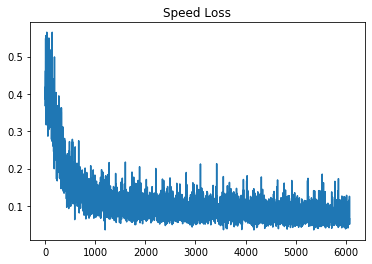

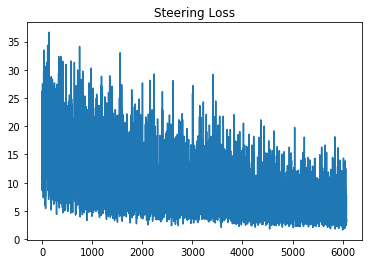

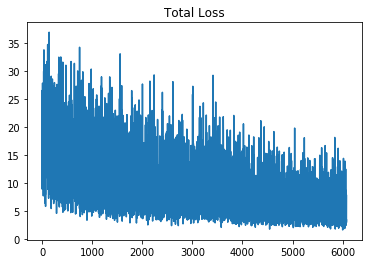

--------------------------------------------------------------
(Resnet50 Model, AdamW optimizer, SmoothL1Loss): 
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch0: 4.28
Steering Error: 26.073894500732422
Speed Error: 66.40896606445312
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch1: 4.21
Steering Error: 26.24321174621582
Speed Error: 47.89215087890625
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch2: 4.23
Steering Error: 27.280162811279297
Speed Error: 47.46835708618164
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch3: 4.22
Steering Error: 28.227449417114258
Speed Error: 49.13186264038086
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch4: 4.21
Steering Error: 40.5286979675293
Speed 

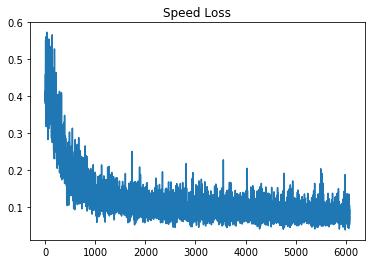

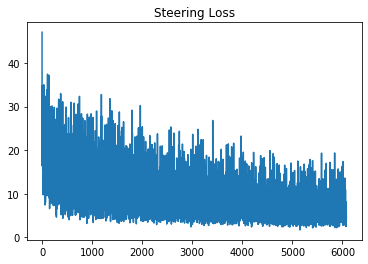

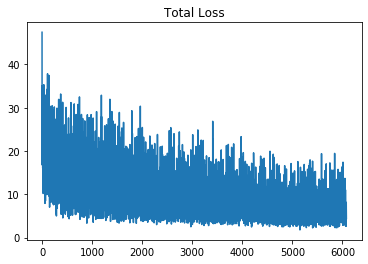

--------------------------------------------------------------
(Resnet50 Model, AdamW optimizer, SmoothL1Loss): 
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch0: 4.22
Steering Error: 31.549951553344727
Speed Error: 66.39419555664062
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch1: 4.22
Steering Error: 34.41797637939453
Speed Error: 53.04791259765625
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch2: 4.24
Steering Error: 26.842220306396484
Speed Error: 44.763187408447266
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Training minutes elapsed epoch3: 4.25
Steering Error: 25.64569664001465
Speed Error: 43.064334869384766


In [ ]:
#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 0, 
#                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss)")

cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 1, 
                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss)")

cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 2, 
                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss)")

cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 3, 
                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss)")

In [ ]:
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizers[0], base_lr=0.000001, max_lr=0.001, cycle_momentum=False)
#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 0, 
#                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss, Cyclic LR)")

## Creating a submission file.

In [ ]:
normalize_targets = config['target']['normalize']
target_mean = config['target']['mean']
target_std = config['target']['std']

def add_results(results, output):
    steering = np.squeeze(output['canSteering'].cpu().data.numpy())
    speed = np.squeeze(output['canSpeed'].cpu().data.numpy())
    if normalize_targets:
        steering = (steering*target_std['canSteering'])+target_mean['canSteering']
        speed = (speed*target_std['canSpeed'])+target_mean['canSpeed']
    if np.isscalar(steering):
        steering = [steering]
    if np.isscalar(speed):
        speed = [speed]
    results['canSteering'].extend(steering)
    results['canSpeed'].extend(speed)

test_chapter_length = [2997 for i in range(98)]
test_chapter_length[14] = 2996
test_chapter_length[36] = 2996
test_chapter_length[38] = 2996
test_chapter_length[63] = 1277
test_chapter_length[64] = 2861
test_chapter_length[66] = 2014
test_chapter_length[70] = 2996
test_chapter_length[72] = 2690
test_chapter_length[81] = 2106
test_chapter_length[85] = 2996
test_chapter_length[92] = 2996

for i in range(len(test_chapter_length)):
    test_chapter_length[i] -= 100
    
print("Number of test data: {}".format(sum(test_chapter_length)))

We use pandas to create a submission file which is simply a 2-column csv with a canSteering and canSpeed prediction for each row in the **drive360_test.csv** a total of 305437 rows/predictions not including the header. See the **sample_submission.csv** file as an example.

IMPORTANT: for the test phase indices will start 10s (100 samples) into each chapter this is to allow challenge participants to experiment with different temporal settings of data input. If challenge participants have a greater temporal length than 10s for each training sample, then they must write a custom function here. Please check out the **dataset.py** file for additional explanation.

In [ ]:
import pandas as pd

def create_submission(model_index, initial_offset, interval, file_name):
    file = './' + file_name + '.csv'
    results = {'canSteering': [],
               'canSpeed': []}

    final_result = {'canSteering': np.zeros(279863, dtype="float64"),
                    'canSpeed': np.zeros(279863, dtype="float64")}
    final_result['canSteering'][:] = np.nan
    final_result['canSpeed'][:] = np.nan


    start = time.time()
    print("Start creating submission file {}, offset:{}, interval:{}".format(file, initial_offset, interval))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            prediction = user_models[model_index](data)
            add_results(results, prediction)
    
    index = 0
    chapter_cap = 0
    r_index = 0
    for chapter_num in test_chapter_length:
        index = chapter_cap + initial_offset
        
        #Fill the leading indices
        final_result['canSteering'][chapter_cap] = results['canSteering'][r_index]
        final_result['canSpeed'][chapter_cap] = results['canSpeed'][r_index]
        
        chapter_cap += chapter_num
        while index < chapter_cap:
            final_result['canSteering'][index] = results['canSteering'][r_index]
            final_result['canSpeed'][index] = results['canSpeed'][r_index]
            
            index += interval
            r_index += 1
            
        #Fill the trailing indices
        #print(index, chapter_cap, r_index)
        final_result['canSteering'][chapter_cap - 1] = results['canSteering'][r_index - 1]
        final_result['canSpeed'][chapter_cap - 1] = results['canSpeed'][r_index - 1]

    df = pd.DataFrame.from_dict(final_result, dtype='float64')
    df.interpolate(method='linear', limit_direction='forward', inplace=True)
    df.to_csv(file, index=False)

    end = time.time() 
    print("Minutes elapsed: {}".format(round((end - start) / 60, 2)))
    
#create_submission(0, 19, 40, "submissions_0")
create_submission(1, config["initial_offset"], config["interval"], "submissions_1")
create_submission(2, config["initial_offset"], config["interval"], "submissions_2")
create_submission(3, config["initial_offset"], config["interval"], "submissions_3")